<a href="https://colab.research.google.com/github/ling-zhang-linnet/risk-aware-dcopf/blob/main/paper_results_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/gdrive')

# Insert the directory
import sys
# sys.path.insert(0,'/content/gdrive/MyDrive/Inbox/reserve_fromLocal')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install pyomo
!apt-get -qq install gcc g++ gfortran git patch wget pkg-config liblapack-dev libmetis-dev
# !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!wget -N -q "https://portal.ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!apt-get install -y -qq glpk-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 4.7 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
Selecting previously unselected package libmetis5:amd64.
(Reading database ... 123941 files and directories currently installed.)
Preparing to unpack .../libmetis5_5.1.0.dfsg-5_amd64.deb ...
Unpacking libmetis5:amd64 (5.1.0.dfsg-5) ...
Selecting previously unselected package libmetis-dev.
Preparing to unpack .../libmetis-dev_5.1.0.dfsg-5_amd64.deb ...
Unpacking libmetis-dev (5.1.0.dfsg-5) ...
Setting up libmetis5:amd64 (5.1.0.dfsg-5) ...
Setting up libmetis-dev (5.1.0.dfsg-5) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123951 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:am

In [4]:
from pyomo.environ import *
# GENERATE ALL DATA
import numpy as np
from scipy.linalg import cholesky
from matplotlib import pyplot as plt
%matplotlib inline

parentFolder = '/content/gdrive/MyDrive/Inbox/Simulation1/'

# params.py


In [5]:
# params.py
# SET PARAMETERS THAT ARE GOING TO BE USED EVERYWHERE

# OPTIONS for caseID:
# no_wind: all generators are regular (controllable)
# wind_penetration: set one of the generators to be wind power
caseID = 'no_wind'

realTimeDemandStdevFactor = 0.05
inputDemandStdevFactor = 0.1

realTimeWindStdevFactor = 0.05
inputWindStdevFactor = 0.1

maxNumInstances = 50000
minNumInstances = 100

nnNumTestFactor = 0.1

nnNumTrain = 50000
nnNumPreTrain = 100
nnNumTest = 1000

maxNumScenarios = 500
minNumScenarios = 10
# use a small number to test if codes run correctly
# numScenarios = minNumScenarios

# to run on google colab, set parentFolder = '/content/gdrive/MyDrive/Your folder path/'
# to run locally:
# parentFolder = ''
paramsPath39Bus = parentFolder + '39bus/params/'
inputDemandPath39Bus = parentFolder + '39bus/inputDemand/'
savedPreTrainPath39Bus = parentFolder + '39bus/savedPreTrain/'
savedTrainPath39Bus = parentFolder + '39bus/savedTrain/'

paramsPath118Bus = parentFolder + '118bus/params/'
inputDemandPath118Bus = parentFolder + '118bus/dataset/'
savedPreTrainPath118Bus = parentFolder + '118bus/savedPreTrainModels/'
savedTrainPath118Bus = parentFolder + '118bus/savedTrainModels/'
summaryPath118Bus = parentFolder + '118bus/summary/'

reservesCostFactor = 1.5
windReservesCostFactor = 0.1

# The default max_iter is 3000
maximumIterations_glpk = 2500
tolerance_glpk = 1e-6

# number of scenarios for estimating cost of recourse stage (i.e., Q) in learning methods
numMCScenarios = 20

# then, generate an independent batch of scenarios for evaluating quality of solutions of ALL METHODS
numAnalyticalScenarios = 10000


# penalty parameters
gammaRes = 10
gammaGen = 1e3
gammaLine = 1e3

delta_line = 0.95
delta_gen = 0.95

theta_max = np.pi/2
theta_min = -theta_max

# data.py

In [6]:
# # GENERATE ALL DATA
# import numpy as np
# from scipy.linalg import cholesky

# from params import *


def generateCorrMat(numBuses, numFactors):
    W = np.random.randn(numBuses, numFactors)
    S = W@W.T + np.diag(np.random.rand(1, numBuses))
    S = np.diag(1. / np.sqrt(np.diag(S))) @ S @ np.diag(1. / np.sqrt(np.diag(S)))
    S = np.round(S, 4)

    return S


def generateInputDemands(predMeanDemand, numBuses, zeroLoads, inputDemandPath):
    assert len(predMeanDemand) == numBuses

    # standard deviation of loads/demands. keep this small enough to be realistic
    demandStdev = inputDemandStdevFactor * predMeanDemand
    # for zero stdev, set them to be small, i.e., 0.1
    demandStdev = np.where(demandStdev < 1e-5, 0.1, demandStdev)

    # randomly generated correlation matrix for the demands
    demandCorrMat = generateCorrMat(numBuses, numBuses)
    np.save(inputDemandPath + 'demandCorrMat.npy', demandCorrMat)

    demandCovMat = np.diag(demandStdev) @ demandCorrMat @ np.diag(demandStdev)
    # store the Cholesky factorization of the demand covariance matrix for numerical efficiency
    demandCovMat_chol = cholesky(demandCovMat, lower=True)

    # tailored implementation of multivariate normal distribution for demand scenarios
    totalNumInstances = nnNumTrain + nnNumPreTrain + nnNumTest
    stdNormalData = np.random.multivariate_normal([0.]*numBuses, np.eye(numBuses), totalNumInstances)
    allData = demandCovMat_chol@stdNormalData.T + np.repeat(predMeanDemand.reshape(-1, 1), totalNumInstances, axis=-1)
    allData = allData.T

    # set zero loads to be zero
    allData[:, zeroLoads] = 0.

    # Alternative way to generate input demands for many instances
    # demandCorrMat = np.eye(numLoads)
    # demandCovMat = np.diag(inputDemandStdev)*demandCorrMat*np.diag(inputDemandStdev)
    # demandCovMat_chol
    # omega_d_tmp = np.random.multivariate_normal(0.0, 1.0, numInstances)
    # allData = demandCovMat_chol*omega_d_tmp + predMeanDemand

    nnTestData = allData[:nnNumTest, :]
    nnPreTrainData = allData[-nnNumPreTrain:, :]
    nnTrainData = allData[nnNumTest:-nnNumPreTrain, :]

    np.save(inputDemandPath + 'nnTrainData.npy', nnTrainData)
    np.save(inputDemandPath + 'nnPreTrainData.npy', nnPreTrainData)
    np.save(inputDemandPath + 'nnTestData.npy', nnTestData)


# generate {numScenarios} real-time demand scenarios for a particular instance
def generateRealTimeScenarios(predMeanDemand, numBuses, zeroLoads, numScenarios,
                              inputDemandPath, windPred=None):

    assert len(predMeanDemand) == numBuses

    # standard deviation of loads/demands. keep this small enough to be realistic
    demandStdev = realTimeDemandStdevFactor * predMeanDemand
    # for zero stdev, set them to be small, i.e., 0.1
    demandStdev = np.where(demandStdev < 1e-5, 0.1, demandStdev)

    # randomly generated correlation matrix for the demands
    demandCorrMat = np.load(inputDemandPath + 'demandCorrMat.npy')

    demandCovMat = np.diag(demandStdev) @ demandCorrMat @ np.diag(demandStdev)
    # store the Cholesky factorization of the demand covariance matrix for numerical efficiency
    demandCovMat_chol = cholesky(demandCovMat, lower=True)

    # tailored implementation of multivariate normal distribution for demand scenarios
    stdNormalData = np.random.multivariate_normal([0.] * numBuses, np.eye(numBuses), numScenarios)
    d_omega = demandCovMat_chol@stdNormalData.T + np.repeat(predMeanDemand.reshape(-1, 1), numScenarios, axis=-1)
    d_omega = d_omega.T

    # set zero load to be zero
    d_omega[:, zeroLoads] = 0.

    w_omega = None
    if caseID == 'wind_penetration' and windPred:
        realTimeWindStdev = realTimeWindStdevFactor * windPred
        # for zero stdev, set them to be small, i.e., 0.1
        realTimeWindStdev = np.where(realTimeWindStdev < 1e-5, 0.1, realTimeWindStdev)

        w_omega = np.random.multivariate_normal(windPred, np.diag(realTimeWindStdev), numScenarios)
        # w_omega = np.clip(w_omega, a_min=0., a_max=None)

    return d_omega, w_omega


# utilities118bus.py

In [7]:
# utilities.py
# UTILITY FUNCTIONS AND DEFINITIONS
import os
import numpy as np
import pandas as pd
import json

# from params import *


# create a new directory if it does not exist
def create_dir(path):
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)
        print("The new directory is created!")


# calculate row-wise l2 distance
def measure_relative_distance(v1, v2):
    distance_vec = np.linalg.norm(v1 - v2, axis=1) / np.linalg.norm(v1, axis=1)

    return np.mean(distance_vec)


def toIntList(numList):
    intList = [int(x) for x in numList]

    return intList


def identifyUniqueLines(ieeeNetwork, connections):
    all_lines = {}
    count = 0
    for line in connections:
        all_lines[count] = line
        count += 1

    # The following codes only find out the repeated lines that have exactly the same order of nodes,
    # but do not deal with the case where [i,j] and [j,i] are also repeated lines
    # Luckily, by checking connections, there is no repeated lines like [i,j] and [j,i]
    unique_lines = {}
    for k, val in all_lines.items():
        if val not in unique_lines.values():
            unique_lines[k] = val

    if ieeeNetwork == '118bus':
        repeated_lines = [[42, 49], [49, 54], [56, 59], [49, 66], [77, 80], [89, 90], [89, 92]]
        # For example, [42, 49] appears twice
        set1 = {}
        set2 = {}
        for k, val in all_lines.items():
            if val in repeated_lines and k in unique_lines:
                set1[val[0], val[1]] = k  # Record the repeated lines when they first appear
            if val in repeated_lines and k not in unique_lines:
                set2[val[0], val[1]] = k  # Record the repeated lines when they appear more than once
    else:
        repeated_lines = []

    return unique_lines, repeated_lines


# read data csv files
def readDataFromFiles(ieeeNetwork, paramsPath):
    print('==== Read data from files. ====')

    allBusesFileName = ieeeNetwork + '_BusData.csv'
    allGenFileName = ieeeNetwork + '_GenData.csv'
    BranchFileName = ieeeNetwork + '_BranchData.csv'

    bus_data_df = pd.read_csv(paramsPath + allBusesFileName, header=None)
    gen_data_df = pd.read_csv(paramsPath + allGenFileName, header=None)
    branch_data_df = pd.read_csv(paramsPath + BranchFileName, header=None)

    # *========== NETWORK TOPOLOGY ==========

    numBuses = bus_data_df.shape[0]
    numGen = gen_data_df.shape[0]
    numRegGen = numGen
    numWindGen = 0
    numLines = branch_data_df.shape[0]

    listOfNums = dict()
    listOfNums['numBuses'] = numBuses
    listOfNums['numGen'] = numGen
    listOfNums['numRegGen'] = numRegGen
    listOfNums['numWindGen'] = numWindGen
    listOfNums['numLines'] = numLines

    bus_data = bus_data_df.to_numpy()
    gen_data = gen_data_df.to_numpy()
    branch_data = branch_data_df.to_numpy()

    # all buses
    maskOutPQBus = [True if bus_data[i, 1] == 1 else False for i in range(bus_data.shape[0])]
    maskOutPVBus = [True if bus_data[i, 1] == 2 else False for i in range(bus_data.shape[0])]
    maskOutSlackBus = [True if bus_data[i, 1] == 3 else False for i in range(bus_data.shape[0])]

    # list of loads at a particular bus (P-Q bus)
    # PQBusList = bus_data[:, 0][maskOutPQBus]
    # loadList = PQBusList
    # listOfNums['numLoads'] = len(loadList)

    # list of regular generators at a particular bus (P-V bus)
    PVBusList = bus_data[:, 0][maskOutPVBus]
    regGenList = gen_data[:, 0].tolist()
    assert len(regGenList) == numGen

    regGenSet = [x - 1 for x in regGenList]
    nonRegGenSet = []
    for x in range(numBuses):
        if x not in regGenSet:
            nonRegGenSet.append(x)

    # slack bus
    slackBus = bus_data[:, 0][maskOutSlackBus][0]
    listOfNums['slackBusNo'] = int(slackBus)

    # check to see if these are type 4 bus
    # assert len(PQBusList) + len(PVBusList) + 1 == numBuses, print('add type 4 buses!')

    # list of wind generators at a particular bus
    windGenList = []
    # if caseID == "wind_penetration":
    # modify windGenList
    # modify regGenList if needed
    genList = list(regGenList) + windGenList

    # form connections as a list of tuples
    connections = []
    branches = branch_data[:, :2]
    for i in range(branches.shape[0]):
        connections.append([int(branches[i, 0]), int(branches[i, 1])])

    if ieeeNetwork == '118bus':
        unique_lines, repeated_lines = identifyUniqueLines(ieeeNetwork, connections)
    else:
        unique_lines, _ = identifyUniqueLines(ieeeNetwork, connections)
    # modify number of lines
    numUniqueLines = len(unique_lines)
    listOfNums['numUniqueLines'] = numUniqueLines

    # *========== DEMAND DATA ===========
    # form nominal demand data
    # note that loads and generators can connect to a same bus
    demandFactor = 1.0
    demand_data = bus_data[:, 2]/10
    demand_data *= demandFactor
    posDemands = []
    posDemandsList = []
    for i, d in enumerate(demand_data):
        if d > 0.:
            posDemands.append(d)
            posDemandsList.append(i + 1)
    # modify number of loads
    numPosDemands = len(posDemands)
    listOfNums['numPosDemands'] = numPosDemands

    # predMeanDemand = [0.0 if idx in regGenSet else x for idx, x in enumerate(demand_data)]
    predMeanDemand = demand_data

    # modify meanDemand if needed
    # i.e., set zero load to be baseLoad in case zero stdev

    # Alternative way to set demands at buses:
    # sumMeanDemand = 280.0 * demandFactor
    # numLoads = 29
    # distributionFactor = np.random.randint(low=1, high=numLoads+1, size=numLoads)
    # distributionFactor /= distributionFactor.sum()
    # meanDemand = [sumMeanDemand*x for x in distributionFactor]

    # *========== GENERATOR BOUNDS ===========
    # lower and upper power bounds for regular generators (p_min and p_max)
    # setting 1:
    # regGenMaxP = gen_data[:, 8]/10
    # setting 2: reference from paper Kannan 2020
    # regGenMaxP = [30.0, 30.0, 30.0, 300.0, 300.0, 30.0, 100.0, 30.0, 30.0, 300.0, 350.0,
    #               30.0, 30.0, 100.0, 30.0, 100.0, 30.0, 30.0, 100.0, 250.0, 250.0, 100.0,
    #               100.0, 200.0, 200.0, 100.0, 420.0, 420.0, 300.0, 80.0, 30.0, 30.0, 20.0,
    #               100.0, 100.0, 300.0, 100.0, 30.0, 300.0, 200.0, 20.0, 50.0, 300.0, 300.0,
    #               300.0, 20.0, 100.0, 100.0, 10000.0, 50.0, 100.0, 100.0, 100.0, 50.0]
    # regGenMaxP = np.array(regGenMaxP) * 5
    # regGenMaxP = regGenMaxP.tolist()
    # setting 3: modified from paper Kannan 2020, by half the bounded bounds
    regGenMaxP = [300., 300., 300., 500., 500., 300., 500., 300., 300., 500.,
                  550., 150., 150., 500., 150., 500., 150., 150., 500., 550.,
                  550., 500., 500., 550., 550., 500., 550., 550., 500., 400.,
                  150., 150., 500., 500., 500., 1500., 500., 150., 500., 550.,
                  500., 250., 500., 500., 500., 500., 500., 500., 500., 250.,
                  500., 500., 500., 250.]
    regGenMaxP = np.array(regGenMaxP) / 2
    # regGenMaxP = regGenMaxP.tolist()

    regGenMinP = gen_data[:, 9]
    # set the most expensive generator (which is bus 4 starting from 0) to have
    # unbounded generation capacity to have complete recourse
    # regGenMaxP[4] = np.inf

    windGenMaxP = [np.inf] * numWindGen
    windGenMinP = [0.0] * numWindGen
    # if caseID == "wind_penetration":
    # modify windGenMinP
    # modify windGenMaxP

    # *========== LINE FLOW LIMITS ===========
    # line flow limits
    lineFlowFactor = 0.85
    # flow_max = branch_data[:, 5]
    # setting1
    # flow_max = np.array([150.0, 150.0, 500.0, 150.0, 150.0, 175.0, 500.0, 500.0,
    #                      500.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 500.0, 500.0,
    #                      500.0, 175.0, 175.0, 500.0, 175.0, 500.0, 175.0, 175.0,
    #                      140.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 500.0, 175.0, 175.0, 500.0, 500.0, 500.0, 500.0,
    #                      500.0, 500.0, 500.0, 175.0, 175.0, 500.0, 175.0, 500.0,
    #                      175.0, 175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 500.0, 500.0, 175.0, 500.0, 500.0, 200.0,
    #                      200.0, 175.0, 175.0, 175.0, 500.0, 500.0, 175.0, 175.0,
    #                      500.0, 500.0, 500.0, 175.0, 500.0, 500.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      200.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0])
    # setting2
    flow_max = np.array([100.0, 100.0, 175.0, 100.0, 100.0, 100.0, 175.0, 175.0,
                         175.0, 100.0, 150.0, 150.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 200.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 200.0, 200.0,
                         200.0, 175.0, 175.0, 200.0, 175.0, 200.0, 175.0, 175.0,
                         140.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 500.0, 175.0, 175.0, 500.0, 500.0, 500.0, 500.0,
                         500.0, 500.0, 500.0, 175.0, 175.0, 500.0, 175.0, 500.0,
                         175.0, 175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 500.0, 500.0, 175.0, 500.0, 500.0, 200.0,
                         200.0, 175.0, 175.0, 175.0, 500.0, 500.0, 175.0, 175.0,
                         500.0, 500.0, 500.0, 175.0, 500.0, 500.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         200.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0]) / 10
    flow_max *= lineFlowFactor

    # *========== FORM WEIGHTED LAPLACIAN ==========
    x = branch_data[:, 3]
    # x = np.array([0.09990, 0.04240, 0.00798, 0.10800, 0.05400, 0.02080, 0.03050, 0.02670,
    #               0.03220, 0.06880, 0.06820, 0.01960, 0.06160, 0.16000, 0.03400, 0.07310,
    #               0.07070, 0.24440, 0.19500, 0.08340, 0.04370, 0.18010, 0.05050, 0.04930,
    #               0.11700, 0.03940, 0.08490, 0.09700, 0.15900, 0.04920, 0.08000, 0.03820,
    #               0.16300, 0.08550, 0.09430, 0.03880, 0.05040, 0.08600, 0.15630, 0.03310,
    #               0.11530, 0.09850, 0.07550, 0.12440, 0.24700, 0.01020, 0.04970, 0.14200,
    #               0.02680, 0.00940, 0.03750, 0.10600, 0.16800, 0.05400, 0.06050, 0.04870,
    #               0.18300, 0.13500, 0.24540, 0.16810, 0.09010, 0.13560, 0.12700, 0.18900,
    #               0.06250, 0.32300, 0.32300, 0.18600, 0.05050, 0.07520, 0.13700, 0.05880,
    #               0.16350, 0.12200, 0.28900, 0.29100, 0.07070, 0.00955, 0.01510, 0.09660,
    #               0.13400, 0.09660, 0.07190, 0.22930, 0.25100, 0.23900, 0.21580, 0.14500,
    #               0.15000, 0.01350, 0.05610, 0.03760, 0.03860, 0.02000, 0.02680, 0.09860,
    #               0.03020, 0.09190, 0.09190, 0.21800, 0.11700, 0.03700, 0.10150, 0.01600,
    #               0.27780, 0.32400, 0.03700, 0.12700, 0.41150, 0.03550, 0.19600, 0.18000,
    #               0.04540, 0.13230, 0.14100, 0.12200, 0.04060, 0.14800, 0.10100, 0.19990,
    #               0.01240, 0.02440, 0.04850, 0.10500, 0.07040, 0.02020, 0.03700, 0.08530,
    #               0.03665, 0.13200, 0.14800, 0.06410, 0.12300, 0.20740, 0.10200, 0.17300,
    #               0.07120, 0.18800, 0.09970, 0.08360, 0.05050, 0.15810, 0.12720, 0.08480,
    #               0.15800, 0.07320, 0.04340, 0.18200, 0.05300, 0.08690, 0.09340, 0.10800,
    #               0.20600, 0.29500, 0.05800, 0.05470, 0.08850, 0.17900, 0.08130, 0.12620,
    #               0.05590, 0.11200, 0.05250, 0.20400, 0.15840, 0.16250, 0.22900, 0.03780,
    #               0.05470, 0.18300, 0.07030, 0.18300, 0.02880, 0.18130, 0.07620, 0.07550,
    #               0.06400, 0.03010, 0.20300, 0.06120, 0.07410, 0.01040, 0.00405, 0.14000, 0.04810, 0.05440])
    b = 1 / x
    # re-scale b by Z0
    # Z0 = 10
    Z0 = 2.
    b = b / Z0

    # form Adjacency matrix
    # A[i, j] = b_(i,j) if "i" is connected to "j"
    # A[i, j] = 0 otherwise
    Adjacency = np.zeros((numBuses, numBuses))
    for k, line in unique_lines.items():
        row = line[0] - 1
        col = line[1] - 1
        Adjacency[row, col] = b[k]
        Adjacency[col, row] = b[k]

    # form weighted Laplacian matrix
    B = np.zeros((numBuses, numBuses))
    for i in range(numBuses):
        for j in range(numBuses):
            if i == j:
                B[i, j] = sum(Adjacency[i, :])
            else:
                B[i, j] = -Adjacency[i, j]

    # BRemovedFirstCol = B[:, 1:]

    # form matrix to convert power injections at all buses to all line flows
    F = np.zeros((numLines, numBuses))

    for i, line in enumerate(connections):
        row = line[0] - 1
        col = line[1] - 1
        F[i, row] = Adjacency[row, col]
        F[i, col] = -Adjacency[row, col]

    # FRemovedFirstCol = F[:, 1:]

    # *========== COST COEFFICIENTS ===========
    # read generator cost data or generate generator cost data
    # regGenCost = [26.2438, 26.2438, 26.2438, 12.8875, 6.8875, 26.2438, 17.8200,
    #               26.2438, 26.2438, 12.8875, 10.7600, 26.2438, 26.2438, 17.8200,
    #               26.2438, 17.8200, 26.2438, 26.2438, 17.8200, 12.3299, 12.3299,
    #               17.8200, 17.8200, 13.2900, 13.2900, 17.8200, 8.3391, 8.3391,
    #               12.8875, 15.4708, 26.2438, 26.2438, 37.6968, 17.8200, 17.8200,
    #               12.8875, 17.8200, 26.2438, 10.7600, 12.8875, 37.6968, 22.9423,
    #               12.8875, 12.8875, 12.8875, 37.6968, 17.8200, 17.8200, 37.6968,
    #               22.9423, 17.8200, 17.8200, 17.8200, 22.9423]
    # regGenCost = np.array(regGenCost)/10
    windGenCost = [0.0] * numWindGen
    # if caseID == "wind_penetration":
    # modify windGenCost

    # *========= STORE RESULTS ==========
    # json.dump(toIntList(list(loadList)), open(paramsPath + 'loadList', 'w'))
    json.dump(toIntList(list(regGenList)), open(paramsPath + 'regGenList', 'w'))
    json.dump(toIntList(list(posDemandsList)), open(paramsPath + 'posDemandsList', 'w'))
    json.dump(listOfNums, open(paramsPath + 'listOfAllNums', 'w'))
    json.dump(connections, open(paramsPath + 'connections', 'w'))
    json.dump(unique_lines, open(paramsPath + 'unique_lines', 'w'))
    np.save(paramsPath + 'predMeanDemand.npy', predMeanDemand)
    np.save(paramsPath + 'regGenMaxP.npy', regGenMaxP)
    np.save(paramsPath + 'regGenMinP.npy', regGenMinP)
    np.save(paramsPath + 'flow_max.npy', flow_max)
    np.save(paramsPath + 'rescaled_b.npy', b)
    np.save(paramsPath + 'Adjacency.npy', Adjacency)
    np.save(paramsPath + 'fullB.npy', B)
    np.save(paramsPath + 'fullF.npy', F)
    # json.dump(regGenCost, open(paramsPath + 'regGenCost', 'w'))

    if caseID == "wind_penetration":
        np.save(paramsPath + 'windGenMaxP.npy', windGenMaxP)
        np.save(paramsPath + 'windGenMinP.npy', windGenMinP)

        json.dump(windGenList, open(paramsPath + 'windGenList', 'w'))
        json.dump(windGenCost, open(paramsPath + 'windGenCost', 'w'))


In [8]:
# redefine paths
paramsPath = paramsPath118Bus
inputDemandPath = inputDemandPath118Bus
savedPreTrainPath = savedPreTrainPath118Bus
savedTrainPath = savedTrainPath118Bus

if not os.path.exists(inputDemandPath):
    create_dir(inputDemandPath)

if not os.path.exists(savedPreTrainPath):
    create_dir(savedPreTrainPath)

if not os.path.exists(savedTrainPath):
    create_dir(savedTrainPath)

# mod118bus.py

In [15]:
# mod118bus.py
# 118 Bus Model based on https://www.maths.ed.ac.uk/optenergy/LocalOpt/118busnetworkmod1.html

import time
from matplotlib import pyplot as plt

# from params import *
# from utilities import *
# from data import *

# OPTIONS for fsConstrainID:
# addFSBalance: add a constraint enforcing that total initial dispatch equals to total forecasted demand
# None
# fsConstrainID = 'addFSBalance'
fsConstrainID = None

# power system definitions
ieeeNetwork = '118bus'

# set seed for reproducibility
np.random.seed(5881)

# redefine paths
paramsPath = paramsPath118Bus
inputDemandPath = inputDemandPath118Bus
savedPreTrainPath = savedPreTrainPath118Bus
savedTrainPath = savedTrainPath118Bus

if not os.path.exists(inputDemandPath):
    create_dir(inputDemandPath)

if not os.path.exists(savedPreTrainPath):
    create_dir(savedPreTrainPath)

if not os.path.exists(savedTrainPath):
    create_dir(savedTrainPath)

# generate all files if they do not exist
readDataFromFiles(ieeeNetwork, paramsPath)

# *========== NETWORK TOPOLOGY ==========
listOfNums = json.load(open(paramsPath + 'listOfAllNums', 'r'))
numBuses = listOfNums['numBuses']
numGen = listOfNums['numGen']
numRegGen = listOfNums['numRegGen']
numWindGen = listOfNums['numWindGen']
# numLoads = listOfNums['numLoads']
# numLines = listOfNums['numUniqueLines']
numLines = listOfNums['numLines']
slackBusNo = listOfNums['slackBusNo']
numPosDemands = listOfNums['numPosDemands']

# map PQ buses to all buses
# loadList = json.load(open(paramsPath + 'loadList', 'r'))
posDemandsList = json.load(open(paramsPath + 'posDemandsList', 'r'))

# mask out buses with zero load
zeroLoadBuses = []
for i in range(numBuses):
    idx = i+1
    if idx not in posDemandsList:
        zeroLoadBuses.append(True)
    else:
        zeroLoadBuses.append(False)

# map regular generators to buses
regGenList = json.load(open(paramsPath + 'regGenList', 'r'))
windGenList = []
if caseID == "wind_penetration":
    windGenList = json.load(open(paramsPath + 'windGenList', 'r'))

regGenSet = [x-1 for x in regGenList]
nonRegGenSet = []
for x in range(numBuses):
    if x not in regGenSet:
        nonRegGenSet.append(x)

# key is bus No. of generator and value is the order among generator set
genAtBus = dict()
visit = []
for i in range(1, numBuses+1):
    if i in regGenList:
        visit.append(i)
        genAtBus[i] = len(visit)  # index starts from 1

# given a bus idx, I want to know its order in regGenList
# ordRegGen = dict()
# for i, idx in enumerate(regGenList):
#     ordRegGen[idx] = i

B = np.load(paramsPath + 'fullB.npy')
F = np.load(paramsPath + 'fullF.npy')

# BRemovedSlack = B[:, 1:]
# FRemovedSlack = F[:, 1:]

# *========== COST COEFFICIENTS ===========
# genCost (c): cost of power from the regular + wind generators
# posResCost (cr_up): cost of up/positive reserves for the regular + wind generators
# negResCost (cr_down): cost of down/negative reserves for the regular + wind generators
# reservesCostFactor
# windReservesCostFactor

# regGenCost = np.round(np.random.uniform(10., 100., numRegGen), 3) / 10
# np.save(paramsPath + 'regGenCost.npy', regGenCost)

# regGenCost = np.load(paramsPath + 'regGenCost.npy')

regGenCost = [26.2438, 26.2438, 26.2438, 12.8875, 6.8875, 26.2438, 17.8200,
            26.2438, 26.2438, 12.8875, 10.7600, 26.2438, 26.2438, 17.8200,
            26.2438, 17.8200, 26.2438, 26.2438, 17.8200, 12.3299, 12.3299,
            17.8200, 17.8200, 13.2900, 13.2900, 17.8200, 8.3391, 8.3391,
            12.8875, 15.4708, 26.2438, 26.2438, 37.6968, 17.8200, 17.8200,
            12.8875, 17.8200, 26.2438, 10.7600, 12.8875, 37.6968, 22.9423,
            12.8875, 12.8875, 12.8875, 37.6968, 17.8200, 17.8200, 37.6968,
            22.9423, 17.8200, 17.8200, 17.8200, 22.9423]
regGenCost = np.array(regGenCost) / 2
np.save(paramsPath + 'regGenCost.npy', regGenCost)

regGenCost = list(regGenCost)
# get the highest cost
max_cost = np.max(regGenCost)
max_costID = np.argmax(regGenCost)
print('max_costID:', max_costID)
print('max_cost:', max_cost)

# *========== NORMALIZE ALL COSTS ===========
# regGenCost = [i/max_cost for i in regGenCost]

# windGenCost = [0.0] * numWindGen
# if caseID == "wind_penetration":
#     windGenCost = json.load(open(paramsPath + 'windGenCost', 'r'))
# genCost = windGenCost + regGenCost

# extend cost vector to be of length numBuses
regGenCost_copy = regGenCost.copy()
genCost_extension = np.zeros(numBuses)
for i in range(numBuses):
    idx = i + 1
    if idx in regGenList:
        genCost_extension[i] = regGenCost_copy.pop(0)

# scale reserves cost by suitable factor
regGenPosResCost = [i * reservesCostFactor for i in regGenCost]
regGenNegResCost = regGenPosResCost

# extend reserve cost to full dimensions by punishing zero demand bus with a large penalty
# full_regGenPosResCost = np.zeros(numBuses)
# for i in range(numBuses):
#     if i in regGenSet:
#         orderAmongGens = genAtBus[i+1] - 1
#         full_regGenPosResCost[i] = regGenPosResCost[orderAmongGens]
#     else:
#         full_regGenPosResCost[i] = max_cost * reservesCostFactor * 5

# full_regGenNegResCost = full_regGenPosResCost

# windGenPosResCost = [0.0] * numWindGen
# windGenNegResCost = [0.0] * numWindGen
# if caseID == "wind_penetration":
#     minRegGenPosResCost = min(regGenPosResCost)
#     minRegGenNegResCost = min(regGenNegResCost)

#     windGenPosResCost = minRegGenPosResCost * windReservesCostFactor * np.ones(numWindGen)
#     windGenNegResCost = minRegGenNegResCost * windReservesCostFactor * np.ones(numWindGen)

# *========== GENERATOR BOUNDS ===========
regGenMaxP = np.load(paramsPath + 'regGenMaxP.npy')
regGenMinP = np.load(paramsPath + 'regGenMinP.npy')

# *========== PRED  MEAN DEMAND ===========
predMeanDemand = np.load(paramsPath + 'predMeanDemand.npy')
max_demand = np.max(predMeanDemand)
max_demandId = np.argmax(predMeanDemand)

# *========== LINE FLOW LIMITS ===========
flow_max = np.load(paramsPath + 'flow_max.npy')
# tighten line flow limits if needed

# *========== INPUT MEAN DEMAND GENERATION ===========
# generate/load in train/pretrain/test input demands
# generateInputDemands(predMeanDemand, numBuses, zeroLoads, inputDemandPath)

nnTrainData = np.load(inputDemandPath + 'nnTrainData.npy')
nnPreTrainData = np.load(inputDemandPath + 'nnPreTrainData.npy')
nnTestData = np.load(inputDemandPath + 'nnTestData.npy')

maxSumPredMean = np.max(np.sum(nnTrainData, axis=1))
inputScalingFactor = np.max(nnTrainData)

maxSumPredMean_overNonGen = np.max(np.sum(nnTrainData, axis=1) - np.sum(nnTrainData[:, regGenSet], axis=1))
# set the most expensive generator to have the largest capacity for complete recourse
# which are buses 74, 91, 104, 110
# this capacity can be inf to use numerical solvers
# but to do learning, inf may encounter numerical issues. in this case, we can set it to be a large enough value.
# sumMeanDemandFactor = 1.5
# regGenMaxP[ordRegGen[74]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[ordRegGen[91]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[ordRegGen[104]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[ordRegGen[110]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[32] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[40] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[45] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[48] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[32] = 10000
regGenMaxP[40] = 1000
# regGenMaxP[45] = 10000
# regGenMaxP[48] = 10000

# *========== REDEFINE BOUNDS DATA ===========
# treat load bus as generators with zero upper bounds
busMinP = np.zeros(numBuses)
busMinP[regGenSet] = regGenMinP

busMaxP = np.zeros(numBuses)
busMaxP[regGenSet] = regGenMaxP

busCost = np.zeros(numBuses)
busCost[regGenSet] = np.array(regGenCost)

busPosResCost = np.zeros(numBuses)
busPosResCost[regGenSet] = np.array(regGenPosResCost)

busNegResCost = np.zeros(numBuses)
busNegResCost[regGenSet] = np.array(regGenNegResCost)

theta_max = np.pi/2

# *========== PRINT INFORMATION ===========
print("numBuses:%d, numGen:%d, numLines:%d, numPosDemands:%d" % (numBuses,
                                                                 numGen, numLines,
                                                                numPosDemands))
print('slack bus is bus %d' % slackBusNo)

print('maxSumPredMean:', maxSumPredMean)
print('SumPredMean:', np.sum(predMeanDemand))
print('generator at bus %d has the highest cost %f' % (regGenList[max_costID], max_cost))
print('bus %d has the highest demand %f' % (max_demandId+1, max_demand))
print('is it a generator?', (int(max_demandId+1) in regGenList))

# for idx, max_c in zip(regGenList, regGenCost):
#     if max_c > 37.0:
#         print('generator at bus %d has cost %f' % (idx, max_c))

# for idx, maxP in zip(regGenList, regGenMaxP):
#     if maxP > 500.0:
#         print('generator at bus %d has capacity %f' % (idx, maxP))

# print('List of loads is ', loadList)
print('List of posDemands is ', posDemandsList)
print('List of regular generators is ', regGenList)
print('List of costs for regular generators is ', regGenCost)
print('regGenMaxP:', regGenMaxP)
print('regGenMinP:', regGenMinP)
print('flow_max:', flow_max)
print('predMeanDemand:', predMeanDemand)

# *========== USE COMMERCIAL SOLVER ===========

# *========== USE LEARNING ===========

# *========== USE GP POLICY ===========


==== Read data from files. ====
max_costID: 32
max_cost: 18.8484
numBuses:118, numGen:54, numLines:186, numPosDemands:99
slack bus is bus 69
maxSumPredMean: 453.892388141243
SumPredMean: 424.2
generator at bus 73 has the highest cost 18.848400
bus 59 has the highest demand 27.700000
is it a generator? True
List of posDemands is  [1, 2, 3, 4, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 66, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118]
List of regular generators is  [1, 4, 6, 8, 10, 12, 15, 18, 19, 24, 25, 26, 27, 31, 32, 34, 36, 40, 42, 46, 49, 54, 55, 56, 59, 61, 62, 65, 66, 69, 70, 72, 73, 74, 76, 77, 80, 85, 87, 89, 90, 91, 92, 99, 100, 103, 104, 105, 107, 110, 111, 112, 113, 116]
List of

# helper functions for evaluation

In [11]:
# CODES FOR GENERATING RESULTS IN THE PAPER

import numpy as np
import cvxpy as cp

from scipy.linalg import cholesky


# helper functions
# prepare first stage solutions
def get_fs_solns(num_instances, fsSolns):
    p0 = np.array(fsSolns['p0'][:num_instances])
    rp = np.array(fsSolns['rp'][:num_instances])
    rd = np.array(fsSolns['rd'][:num_instances])
    gen_cost = np.array(fsSolns['c_gen'][:num_instances])
    res_cost = np.array(fsSolns['c_res'][:num_instances])
    fs_cost = np.array(fsSolns['c_fs'][:num_instances])

    return p0, rp, rd, gen_cost, res_cost, fs_cost


# generate an independent set of scenarios
def generateMCScenarios(pred_mean_demand, num_mc):
    """
    :param pred_mean_demand: for a single instance
    :param num_mc: 500 scenarios for evaluation
    :return: d_omega of size (numBuses, numMC)
    """
    num_instances = pred_mean_demand.shape[0]

    # standard deviation of loads/demands. keep this small enough to be realistic
    demandStdev = realTimeDemandStdevFactor * pred_mean_demand
    # for zero stdev, set them to be small, i.e., 0.1
    demandStdev = np.where(demandStdev < 1e-5, 0.1, demandStdev)

    # randomly generated correlation matrix for the demands
    # or load existed correlation matrix
    demandCorrMat = np.load(inputDemandPath + 'demandCorrMat.npy')
    demandCovMat = np.diag(demandStdev) @ demandCorrMat @ np.diag(demandStdev)
    # store the Cholesky factorization of the demand covariance matrix for numerical efficiency
    demandCovMat_chol = cholesky(demandCovMat, lower=True)

    # tailored implementation of multivariate normal distribution for demand scenarios
    stdNormalData = np.random.multivariate_normal([0.] * numBuses, np.eye(numBuses), num_mc)
    d_omega = demandCovMat_chol @ stdNormalData.T + np.repeat(pred_mean_demand.reshape(-1, 1), num_mc, axis=-1)
    d_omega = d_omega.T

    # set zero load to be zero
    d_omega[:, zeroLoadBuses] = 0.

    return d_omega


# solve recourse problem
def solveRecourse(input_demands, all_d_omega, p0_soln, rp_soln, rd_soln,
                  fs_cost, gamma_res, return_rcs_solns=False):
    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    numInstance = input_demands.shape[0]
    numScenarios = all_d_omega.shape[0]

    # dictionary to store recourse solutions in case return_rcs_solns is true
    rcs_solns = dict()
    rcs_solns['d_omega'] = np.zeros((numBuses, numInstance))
    rcs_solns['theta'] = []
    rcs_solns['p_tilde'] = []
    if return_rcs_solns:
        # there will only be a single scenario for each instance under this setting
        rcs_solns['d_omega'] = all_d_omega[0, :, :]

    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    busSet = range(numBuses)
    scenSet = range(numScenarios)

    busMaxP_copy = busMaxP.reshape(-1, 1)
    busMinP_copy = busMinP.reshape(-1, 1)
    flow_max_copy = flow_max.reshape(-1, 1)

    # dictionary to store results for all instances
    eval_solns = dict()
    eval_solns['Status'] = []
    eval_solns['fs_cost'] = []
    eval_solns['rcsCost'] = []
    eval_solns['evaluateTotalCost'] = []

    for t in range(numInstance):
        start_time = time.time()

        # *====== FOR EACH INSTANCE =======
        d_omega = all_d_omega[:, :, t].T
        # print('d_omega:', d_omega.shape)

        # recourse variables
        p_tilde = cp.Variable(shape=(numBuses, numScenarios), name='p')
        theta = cp.Variable(shape=(numBuses, numScenarios), name='theta')

        constraints = [
            theta <= theta_max * np.ones_like(theta),
            theta >= -theta_max * np.ones_like(theta),
            theta[slackBusNo - 1, :] == np.zeros(numScenarios),
            p0_soln[t:t + 1, :].T + p_tilde <= np.repeat(busMaxP_copy, numScenarios, axis=1),
            p0_soln[t:t + 1, :].T + p_tilde >= np.repeat(busMinP_copy, numScenarios, axis=1),
            F @ theta <= np.repeat(flow_max_copy, numScenarios, axis=1),
            F @ theta >= -np.repeat(flow_max_copy, numScenarios, axis=1),
            p0_soln[t:t + 1, :].T + p_tilde == B @ theta + d_omega
        ]

        # print('busPosResCost:', busPosResCost.shape)
        # print('p_tilde:', p_tilde.shape)
        # print('p0_soln:', p0_soln.shape)

        cost = (1.0 / numScenarios) * sum(
            gamma_res * busPosResCost[i] * cp.maximum(p_tilde[i, scen] - rp_soln[t, i], 0.0) +
            gamma_res * busNegResCost[i] * cp.maximum(- rd_soln[t, i] - p_tilde[i, scen], 0.0)
            for scen in scenSet for i in busSet)

        problem = cp.Problem(cp.Minimize(cost), constraints)

        problem.solve(solver=cp.ECOS)

        # if problem.status not in ["infeasible", "unbounded"]:
        #     # Otherwise, problem.value is inf or -inf, respectively.
        #     print("Optimal value: %s" % problem.value)
        #     for variable in problem.variables():
        #         print("Variable %s: value %s" % (variable.name(), variable.value))

        if problem.status in ["infeasible", "unbounded"]:
            print("Model not solved to (sub)optimality using CVXPY!!!")
            print("solve_status: ", problem.status)

            eval_solns['Status'] += [str(problem.status)]
            eval_solns['fs_cost'] += [fs_cost[t]]
            eval_solns['rcsCost'] += [np.inf]
            eval_solns['evaluateTotalCost'] += [np.inf]

            if return_rcs_solns:
                rcs_solns['theta'].append([np.inf] * numBuses)
                rcs_solns['p_tilde'].append([np.inf] * numBuses)

            # sys.exit(0)
            continue

        print("Instance: %d Problem status: %s " % (t, problem.status))

        eval_solns['Status'] += [str(problem.status)]
        eval_solns['fs_cost'] += [fs_cost[t]]
        eval_solns['rcsCost'] += [cost.value.item()]
        eval_solns['evaluateTotalCost'] += [fs_cost[t] + cost.value.item()]

        if return_rcs_solns:
            rcs_solns['theta'].append(list(theta.value[:, 0]))
            rcs_solns['p_tilde'].append(list(p_tilde.value[:, 0]))

        # print('\nEvaluation tims for instance %d is %.2f minutes.' % (t, (time.time() - start_time) / 60))

    return eval_solns, rcs_solns


def evaluate(input_demands, num_intances, fs_solns, mc_scenarios):
    p0_soln, rp_soln, rd_soln, Cgen, Cres, Cfs = get_fs_solns(num_intances, fs_solns)
    # call solve_recourse function

    eval_solns, _ = solveRecourse(input_demands, mc_scenarios, p0_soln, rp_soln, rd_soln,
                                  Cfs, gamma_res=gammaRes)

    return eval_solns['Status'], eval_solns['rcsCost']

# evaluation

In [13]:
# set paths
# simulation1: not add balance constraint in the first stage
# simulation2: add balance constraint in the first stage
# both results: gamma_gen=1e3, gamma_line=1e3, flow_max/=0.85
parentFolder = '/content/gdrive/MyDrive/Inbox/Simulation1/'
parentFolder2 = '/content/gdrive/MyDrive/Inbox/Simulation2/'

paramsPath118Bus = parentFolder + '118bus/params/'
inputDemandPath118Bus = parentFolder + '118bus/dataset/'
savedPreTrainPath118Bus = parentFolder + '118bus/savedPreTrainModels/'
savedTrainPath118Bus = parentFolder + '118bus/savedTrainModels/'

paramsPath = paramsPath118Bus
inputDemandPath = inputDemandPath118Bus
savedPreTrainPath = savedPreTrainPath118Bus
savedTrainPath = savedTrainPath118Bus

test_data = np.load(inputDemandPath + 'nnTestData.npy')

# load model results
fsSolns_test_orig_sce300_instant1 = json.load(open(savedTrainPath + 'fsSolns_test_orig_sce300', 'r'))
fsSolns_test_pen_sce300_instant1 = json.load(open(savedTrainPath + 'fsSolns_test_pen_sce300', 'r'))

fsSolns_test_orig_sce100_instant50 = json.load(open(savedTrainPath + 'fsSolns_test_orig', 'r'))
fsSolns_test_pen_sce100_instant1 = json.load(open(savedTrainPath + 'fsSolns_test_pen_sce100', 'r'))

fsSolns_test_nn_instant200 = json.load(open(parentFolder2+'118bus/savedTrainModels/' + 'fsSolns_test_nn200', 'r'))

In [48]:
# generate an independent set of scenarios for evaluation
# *========== for 50 instance  ===========
numIntances = 1
inputDemands = test_data[:numIntances, :]
numMC = 100

allScenarios = np.zeros((numMC, numBuses, numIntances))
for inst in range(numIntances):
    allScenarios[:, :, inst] = generateMCScenarios(inputDemands[inst, :], numMC)

# define dictionary to store recourse problem results
nnModel_rcs_cost = {'status': [], 'rcsCost': [], 'expectedTotalCost': []}
origModel_rcs_cost = {'status': [], 'rcsCost': [], 'expectedTotalCost': []}
penModel_rcs_cost = {'status': [], 'rcsCost': [], 'expectedTotalCost': []}

for sce in range(numMC):
    status_nn, rcsCost_nn = evaluate(inputDemands, numIntances,
                                     fsSolns_test_nn_instant200, allScenarios[sce:sce + 1, :, :])
    status_orig, rcsCost_orig = evaluate(inputDemands, numIntances,
                                         fsSolns_test_orig_sce100_instant50, allScenarios[sce:sce + 1, :, :])
    
    status_pen, rcsCost_pen = evaluate(inputDemands, numIntances,
                                       fsSolns_test_pen_sce100_instant1, allScenarios[sce:sce + 1, :, :])

    nnModel_rcs_cost['status'].append(status_nn)
    nnModel_rcs_cost['rcsCost'].append(rcsCost_nn)

    origModel_rcs_cost['status'].append(status_orig)
    origModel_rcs_cost['rcsCost'].append(rcsCost_orig)

    penModel_rcs_cost['status'].append(status_pen)
    penModel_rcs_cost['rcsCost'].append(rcsCost_pen)

Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
Instance: 0 Problem status: optimal 
I

In [49]:
p0_nn, rp_nn, rd_nn, Cgen_nn, Cres_nn, Cfs_nn = get_fs_solns(numIntances, fsSolns_test_nn_instant200)
p0_orig, rp_orig, rd_orig, Cgen_orig, Cres_orig, Cfs_orig = get_fs_solns(numIntances, fsSolns_test_orig_sce100_instant50)
p0_pen, rp_pen, rd_pen, Cgen_pen, Cres_pen, Cfs_pen = get_fs_solns(numIntances, fsSolns_test_pen_sce100_instant1)

In [50]:
Crcs_nn = np.array(nnModel_rcs_cost['rcsCost']).T
Crcs_orig = np.array(origModel_rcs_cost['rcsCost']).T
Crcs_pen = np.array(penModel_rcs_cost['rcsCost']).T

expectedTotalCost_nn = Crcs_nn + Cfs_nn.reshape(-1, 1)
expectedTotalCost_orig = Crcs_orig + Cfs_orig.reshape(-1, 1)
expectedTotalCost_pen  = Crcs_pen + Cfs_pen.reshape(-1, 1)


In [52]:
print(Crcs_nn.shape)
print(Crcs_orig.shape)
print(Crcs_pen.shape)

(1, 100)
(1, 100)
(1, 100)


In [53]:
print(expectedTotalCost_nn.mean())
print(expectedTotalCost_orig.mean())
print(expectedTotalCost_pen.mean())

3170.2280667700684
2914.8686049395806
7235.70600577458


In [54]:
print(Cgen_nn.mean())
print(Cgen_orig.mean())
print(Cgen_pen.mean())

2797.594239241457
2795.7016996653033
4974.862916806261


In [55]:
print(Cres_nn.mean())
print(Cres_orig.mean())
print(Cres_pen.mean())

369.17916006748976
79.65516596300783
1425.666184617654


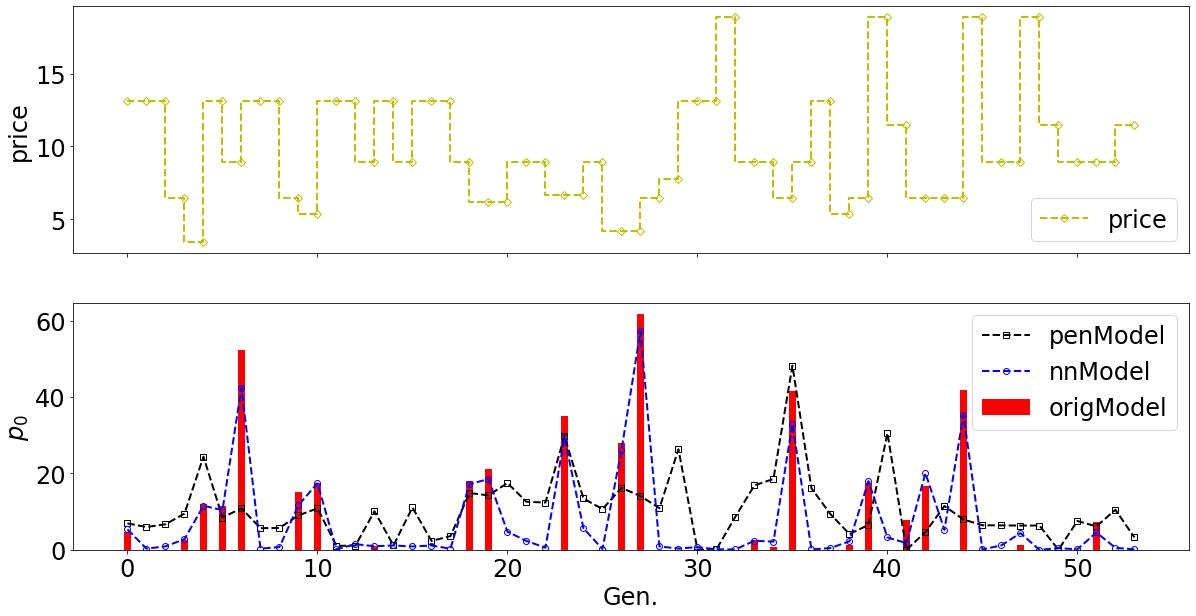

orig: 419.1609571183826
pen: 563.0744607310044
nn: 408.8770308494568


In [77]:
fig, [ax1, ax] = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

ax.bar(range(numRegGen), p0_orig[0, regGenSet], width=0.4, color='r', label='origModel')
ax.plot(p0_pen[0, regGenSet], 'k--s', lw=2, markerfacecolor='None', label='penModel')
ax.plot(p0_nn[0, regGenSet], 'b--o', lw=2, markerfacecolor='None', label='nnModel')

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.set_xlabel('Gen.', fontsize=24)
ax.set_ylabel(r'$p_0$', fontsize=24)

# ax1 = ax.twinx()
ax1.step(range(numRegGen), regGenCost, 'y--D', lw=2, markerfacecolor='None', label='price')
ax1.legend(fontsize=24, loc='lower right')
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
# ax1.set_xlabel('Gen.', fontsize=24)
ax1.set_ylabel('price', fontsize=24, rotation=90)

ax.legend(fontsize=24)
plt.savefig(savedTrainPath + 'p0.png')
plt.show()

print('orig:', sum(p0_orig[0, :]))
print('pen:', sum(p0_pen[0, :]))
print('nn:', sum(p0_nn[0, :]))

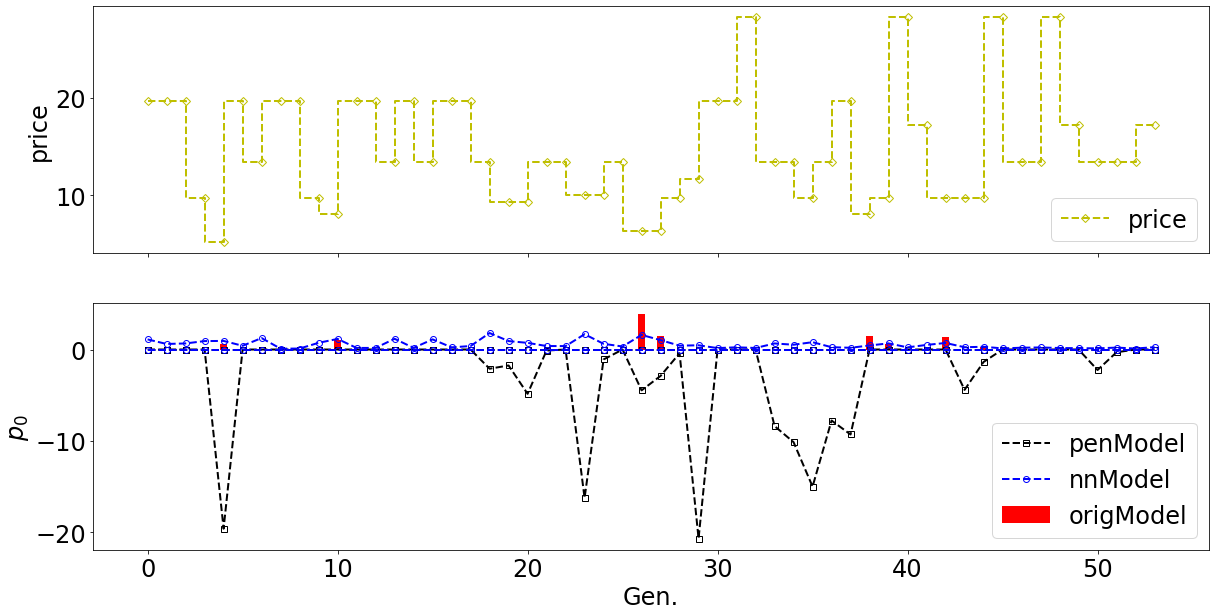

orig: 10.876091123771916
pen: 133.28071427229713
nn: 29.463669449090958


In [79]:
fig, [ax1, ax] = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

ax.bar(range(numRegGen), rp_orig[0, regGenSet], width=0.4, color='r', label='origModel')
ax.bar(range(numRegGen), -rd_orig[0, regGenSet], width=0.4, color='r')
ax.plot(rp_pen[0, regGenSet], 'k--s', lw=2, markerfacecolor='None', label='penModel')
ax.plot(-rd_pen[0, regGenSet], 'k--s', lw=2, markerfacecolor='None')
ax.plot(rp_nn[0, regGenSet], 'b--o', lw=2, markerfacecolor='None', label='nnModel')
ax.plot(-rd_nn[0, regGenSet], 'b--o', lw=2, markerfacecolor='None')

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.set_xlabel('Gen.', fontsize=24)
ax.set_ylabel(r'$p_0$', fontsize=24)

# ax1 = ax.twinx()
ax1.step(range(numRegGen), regGenPosResCost, 'y--D', lw=2, markerfacecolor='None', label='price')
ax1.legend(fontsize=24, loc='lower right')
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
# ax1.set_xlabel('Gen.', fontsize=24)
ax1.set_ylabel('price', fontsize=24, rotation=90)

ax.legend(fontsize=24)
plt.savefig(savedTrainPath + 'rp_rd.png')
plt.show()

print('orig:', sum(rp_orig[0, :]) + sum(rd_orig[0, :]) )
print('pen:', sum(rp_pen[0, :]) + sum(rd_pen[0, :]) )
print('nn:', sum(rp_nn[0, :]) + sum(rd_nn[0, :]) )